In [1]:
%matplotlib inline

In [80]:
import pandas as pd
import geopandas as gpd
import matplotlib.patches as patches
import matplotlib.pyplot as plt
from scipy import ndimage, misc
import numpy as np
from scipy.interpolate import UnivariateSpline
from scipy.signal import find_peaks
#!pip install scikit-image

In [152]:
ruch = pd.read_csv('/home/dominik.mielczarek/TreeQuant/Interpolation/ruch.csv')
ruch = ruch.iloc[:,:]

In [153]:
ruch['x_center'] = ruch['x1'] + ((ruch['x2'] - ruch['x1'])*.5)
ruch['y_center'] = ruch['y1'] + ((ruch['y2'] - ruch['y1'])*.5)
ruch['ID']  = [x for x in range(ruch['y_center'].size)]

In [154]:
ruch.head()

,x1,y1,x2,y2,step,time,direction,x_center,y_center,ID
0,10,10,110,110,0,0.000000,1,60.0,60.0,0
1,11,11,111,111,1,0.017452,1,61.0,61.0,1
2,14,14,114,114,2,0.034899,1,64.0,64.0,2
3,19,19,119,119,3,0.052336,1,69.0,69.0,3
4,25,25,125,125,4,0.069756,1,75.0,75.0,4


## Data Exploration

In [169]:
def Euc_Distance(df):
    distance = []
    for i in range(df['x_center'].size):
        if i==0:
            distance.append(0)
        else:
            distance.append(((df.iloc[i,0] - df.iloc[i-1,0])**2)+((df.iloc[i,1] - df.iloc[i-1,1])**2))
    return distance

ruch = ruch.sort_values(by=['step'])
ruch['distance'] = Euc_Distance(ruch[['x_center', 'y_center']])

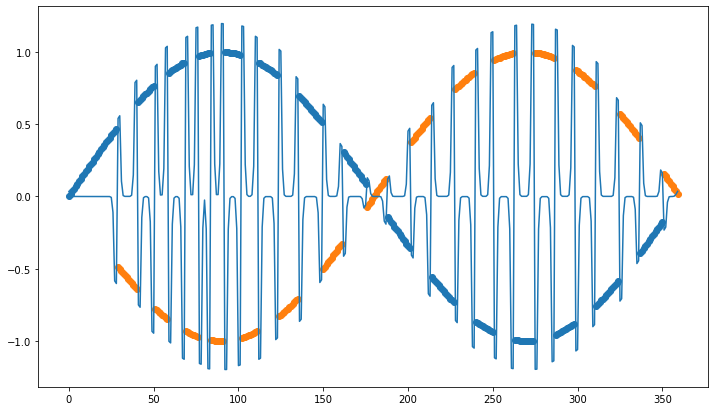

In [497]:
fig = plt.figure(figsize=(12, 7))

plt.scatter(ruch_neg1['step'], ruch_neg1['time'])
plt.scatter(ruch_pos1['step'], ruch_pos1['time'])

result = ndimage.gaussian_laplace(ruch['time'], sigma=1)

plt.plot(ruch['step'], result*3)

plt.show()

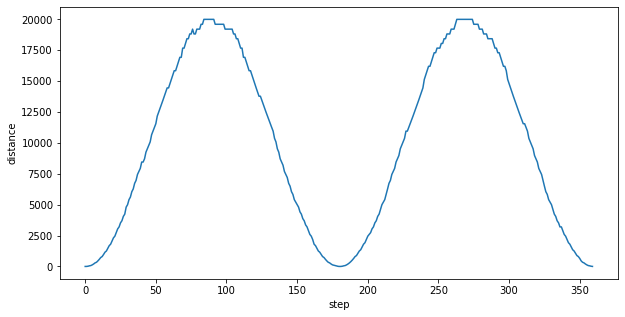

In [243]:
fig,  (ax1) = plt.subplots(1, 1)
fig.set_figheight(5)
fig.set_figwidth(10)

ax1.plot(ruch['step'],
         ruch['distance'])

ax1.set_xlabel('step')
ax1.set_ylabel('distance')
plt.show()

In [176]:
ruch_pos1 = ruch[ruch['direction'] == -1]
ruch_neg1 = ruch[ruch['direction'] == 1]

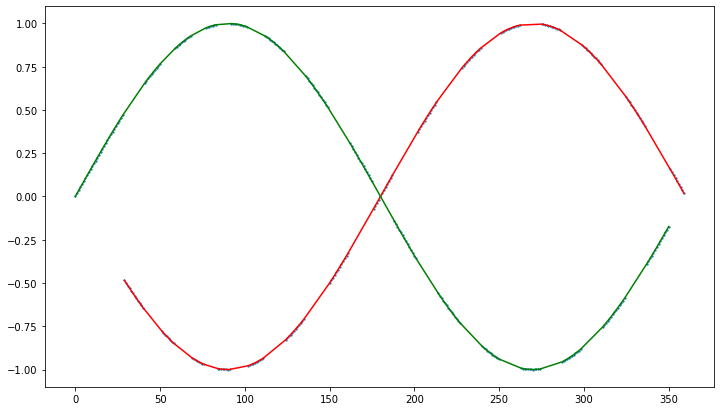

In [337]:
fig = plt.figure(figsize=(12, 7))

plt.scatter(ruch['step'], ruch['time'],s=1.5)
plt.plot(ruch_pos1['step'], ruch_pos1['time'], c='red')
plt.plot(ruch_neg1['step'], ruch_neg1['time'], c='green')

plt.show()

In [194]:
ruch_pos1 = ruch[ruch['direction'] == -1]
ruch_neg1 = ruch[ruch['direction'] == 1]

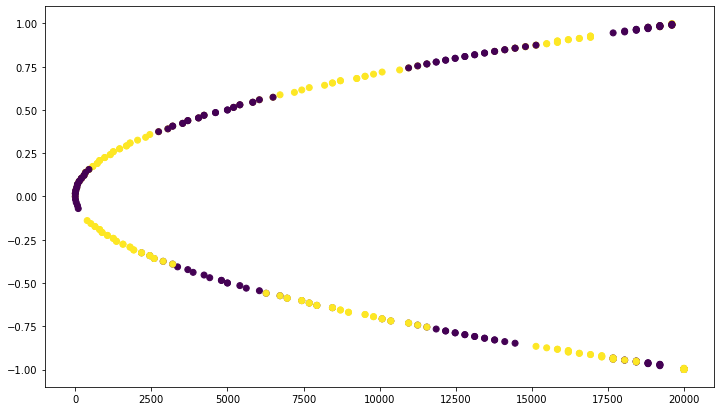

In [290]:
fig = plt.figure(figsize=(12, 7))
plt.scatter(ruch['distance'], ruch['time'], c = ruch['direction'])
plt.show()

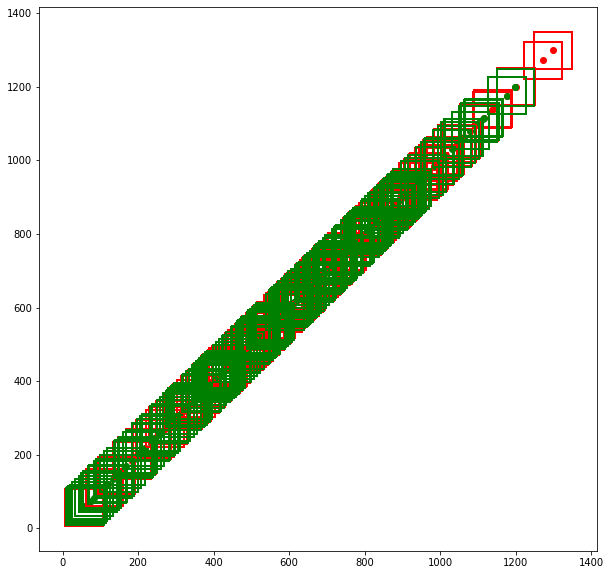

In [245]:
fig,ax = plt.subplots(1,figsize=(10, 10))
#fig = plt.figure(figsize=(20, 10))
ax.scatter(ruch_pos1['x_center'], ruch_pos1['y_center'],c='red')
ax.scatter(ruch_neg1['x_center'], ruch_neg1['y_center'],c='green')
colors = ['r','g']
N=-1

for var in [ruch_pos1, ruch_neg1]:
    N+=1
    for i in range(var['x1'].size): 

        rect = patches.Rectangle((var.iloc[i,0], 
                                  var.iloc[i,1]),
                                 var.iloc[i,2]-var.iloc[i,0],
                                 var.iloc[i,3]-var.iloc[i,1],
                                 linewidth=2,
                                 edgecolor=colors[N],
                                 facecolor='none')
        ax.add_patch(rect)
    
plt.show()

In [222]:
from skimage.filters import laplace
from scipy import interpolate
import numpy as np

In [246]:
z_neg = ruch_neg1['time']
step_neg = ruch_neg1['step']

z_neg = np.array(z_neg).reshape((-1 ))
step_neg = np.array(step_neg).reshape((-1 ))

f_neg = interpolate.interp1d(step_neg, z_neg, axis=0, kind='cubic', fill_value="extrapolate")
w_neg = f_neg(z_neg) 

In [498]:
z_pos = ruch_pos1['time']
step_pos = ruch_pos1['step']

z_pos = np.array(z_pos).reshape((-1 ))
step_pos = np.array(step_pos).reshape((-1 ))

f_pos = interpolate.interp1d(step_pos, z_pos, axis=0, kind='cubic', fill_value="extrapolate")

#xnew = np.arange(0, 360, 0.1)

w_pos = f_neg(z_pos) 

### First Approach 

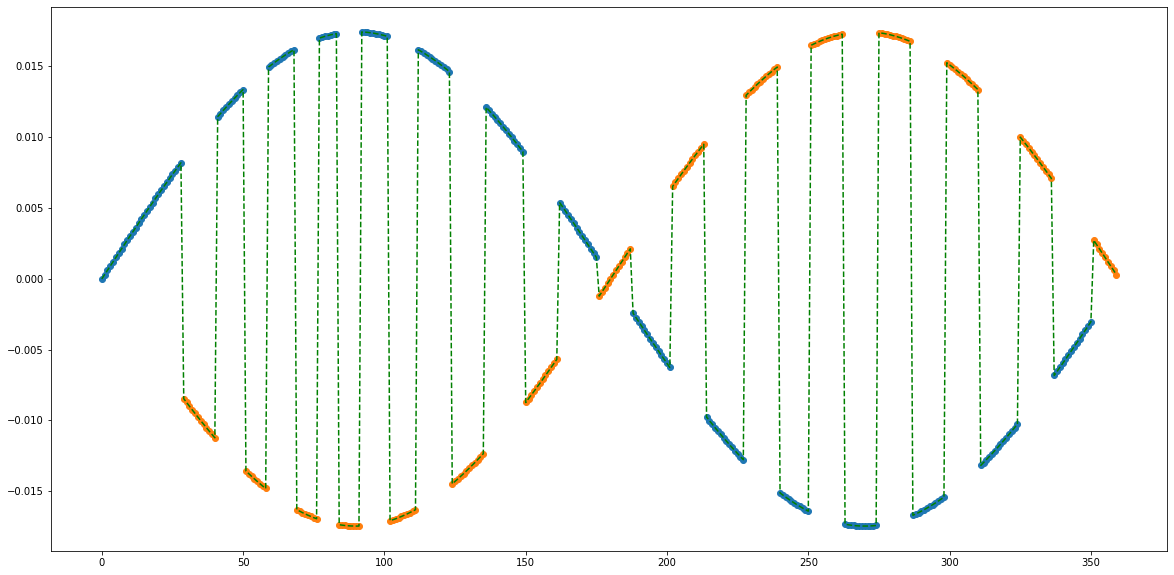

In [443]:
fig = plt.figure(figsize=(20, 10))

plt.scatter(step_neg,w_neg)
#plt.plot(step_neg,w_neg, c='red')

plt.scatter(step_pos,w_pos)
#plt.plot(step_pos,w_pos, c='green')

result = ndimage.gaussian_laplace(ruch['distance'], sigma=2)

y_spl = UnivariateSpline(ruch['step'],
                         ruch['time'],
                         w=ruch['direction'],
                         s=0,
                         k=2,
                         ext=0)

ruch['spline'] = y_spl(ruch['time'])

plt.plot(ruch['step'], ruch['spline'],c='green', ls='--')
plt.show()

## Second Approach 

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/pandas/core/series.py:1020: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._where(~key, value, inplace=True)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/pandas/core/series.py:1020: Se

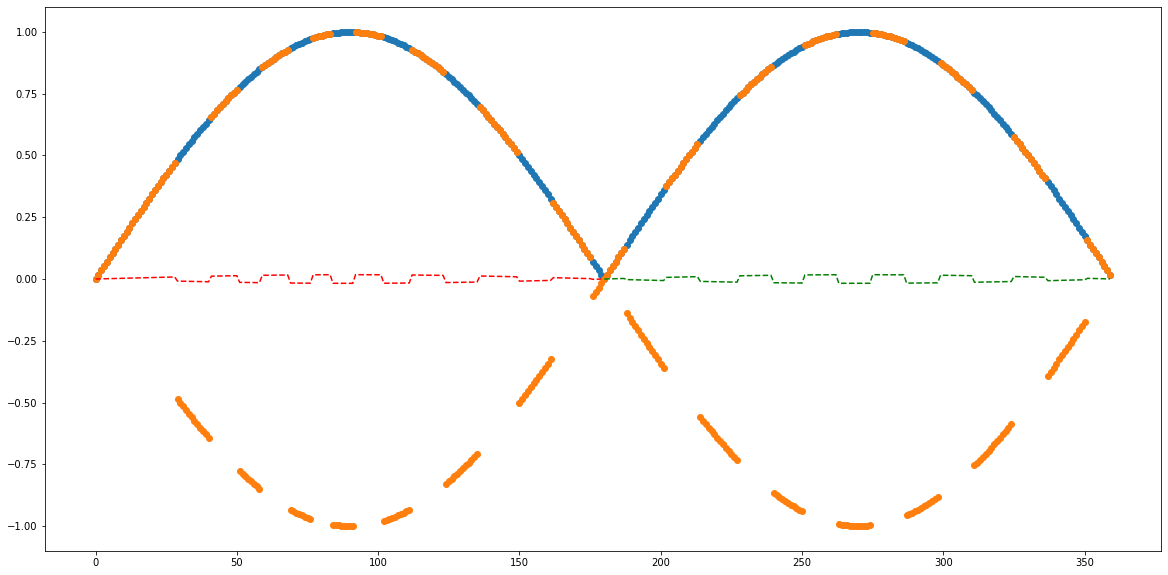

In [523]:
fig = plt.figure(figsize=(20, 10))
plt.scatter(ruch['step'],(ruch['time']**2)**0.5)
plt.scatter(ruch['step'],ruch['time'])

#Univariate Polynomial Interpolation
y_spl = UnivariateSpline(ruch['step'], 
                         (ruch['time']**2)**0.5,
                         w=ruch['direction'],
                         s=0,
                         k=5, 
                         ext=2)

ruch['spline'] = y_spl((ruch['time']**2)**0.5)

#Gaussian + Laplacian filtering
result = ndimage.gaussian_laplace((ruch['time']**2)**0.5, sigma=5)
peaks, _ = find_peaks(result)

ruch1 = ruch.iloc[:peaks[0]]
ruch2 = ruch.iloc[peaks[0]:]

#Function construction
ruch1['spline'][ruch1['direction'] == -1] = ruch1['spline'] * -1
ruch2['spline'][ruch2['direction'] == 1] = ruch2['spline'] * -1

plt.plot(ruch1['step'], ruch1['spline']*1  ,c='red', ls='--')
plt.plot(ruch2['step'], ruch2['spline']*1,c='green', ls='--')

plt.plot(peaks, result[peaks])
plt.show()

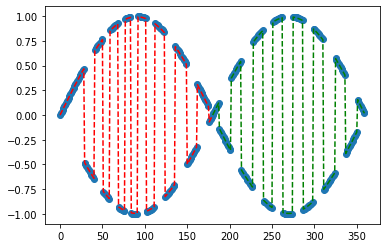

In [495]:
plt.scatter(ruch['step'],ruch['time'] )
plt.plot(ruch1['step'],ruch1['spline']*57 ,c='red', ls='--')
plt.plot(ruch2['step'],ruch2['spline']*57 ,c='green', ls='--')